In [1]:
#conda-env-analysis3-20.01
import sys
sys.path.append('/g/data1a/e14/as3189/OFAM/scripts/')
import gsw
import numpy as np
import xarray as xr
from scipy import stats
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from main import paths, idx_1d, LAT_DEG, lx
from matplotlib.offsetbox import AnchoredText
from main_valid import EUC_depths, plot_eq_velocity
from main_valid import open_tao_data, plot_tao_timeseries, cor_scatter_plot
import datetime

In [2]:
# Path to save figures, save data and OFAM model output.
fpath, dpath, xpath, lpath, tpath = paths()

z1 = 50
z2 = 300
dt = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))
dt = dt.sel(st_ocean=slice(z1, z2))

# Saved data frequency (1 for monthly and 0 for daily data).
T = 1

# Open dataset of TAO data at the frequency.
ds = open_tao_data(frq=lx['frq_short'][T], dz=slice(10, 360))

INFO: Opening TAO mon data. Depth=slice(10, 360, None). SI=True


In [87]:
# Add transport between depths.
dtt = dt.uvo.isel(st_ocean=0).copy()*np.nan

# Add velocity between depths.
dv = dt.u.isel(st_ocean=0).copy()*np.nan

for i in range(3):
    dq = dt.sel(xu_ocean=lx['lons'][i])
    v_max, depth_vmax, depth_end = EUC_depths(dq.u, dq.st_ocean, i, log=False)
    for t in range(len(dt.Time)):
        if not np.isnan(depth_end[t]):
            # Transport
            tmp1 = dt.uvo.isel(xu_ocean=i, Time=t)
            dtt[t, i] = tmp1.where(tmp1 > 0).sel(
                st_ocean=slice(z1, depth_end[t].item())).sum(dim='st_ocean').item()
            # Velocity
            tmp2 = dt.u.isel(xu_ocean=i, Time=t)
            dv[t, i] = tmp2.where(tmp2 > 0).sel(
                st_ocean=slice(z1, depth_end[t].item())).sum(dim='st_ocean').item()           

INFO: EUC_depths: 0:0:00.36 total: 0.36 seconds.
INFO: EUC_depths: 0:0:00.26 total: 0.26 seconds.
INFO: EUC_depths: 0:0:00.28 total: 0.28 seconds.


INFO: slope=1.73, intercept=1.69, r=0.89, p=0.00, std_err=0.05
INFO: slope=1.79, intercept=-4.65, r=0.85, p=0.00, std_err=0.07
INFO: slope=1.36, intercept=-8.91, r=0.82, p=0.00, std_err=0.05


SpearmanrResult(correlation=0.9229580097785447, pvalue=1.1378140160829023e-127)
SpearmanrResult(correlation=0.8563451224251846, pvalue=7.59083869368165e-73)
SpearmanrResult(correlation=0.7857983322699171, pvalue=2.3686584439734838e-64)


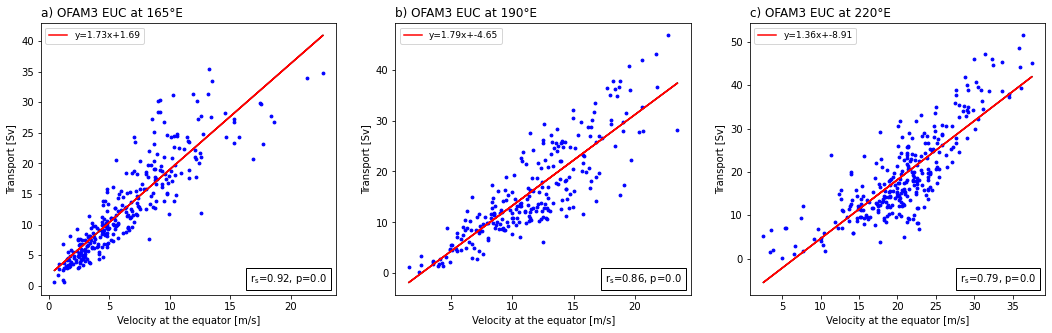

In [178]:
# Equatorial Trnasport and Velocity correlation.
fig = plt.figure(figsize=(18, 5))
m, b = np.zeros(3), np.zeros(3)
for i in range(3):
    m[i], b[i] = cor_scatter_plot(fig, i+1, dv.isel(xu_ocean=i),
                                  dtt.isel(xu_ocean=i)/1e6,                                  
                                  name='{}OFAM3 EUC at {}°E'.format(
                                      lx['l'][i], lx['lons'][i]),
                                  ylabel="Transport [Sv]",
                                  xlabel="Velocity at the equator [m/s]")#,cor_loc=4)

save_name = 'ofam3_eq_transport_velocity_cor.png'
plt.savefig(fpath.joinpath('tao', save_name))

# TAO transport

In [179]:
ds_sum = [ds[i].u_1205.isel(depth=0)*np.nan for i in range(3)]
for i in range(3):
    depth_end_tao = EUC_depths(ds[i].u_1205, ds[i].depth, i)[2]
    for t in range(len(ds[i].u_1205.time)):
        if not np.isnan(depth_end_tao[t]):
            tmp = ds[i].u_1205.isel(time=t).sel(depth=slice(z1, depth_end_tao[t]))
            dz = tmp.depth.values
            ds_sum[i][t] = (tmp*dz).where(tmp > 0).sum(dim='depth').item()

INFO: TAO/TRITION 165: v_bnd=0.1 count=86 tot=203, skipped=112 empty=5 eps=0.05.
INFO: EUC_depths: 0:0:00.20 total: 0.20 seconds.
INFO: TAO/TRITION 190: v_bnd=0.1 count=200 tot=340, skipped=104 empty=36 eps=0.05.
INFO: EUC_depths: 0:0:00.22 total: 0.22 seconds.
INFO: TAO/TRITION 220: v_bnd=0.1 count=232 tot=311, skipped=48 empty=31 eps=0.05.
INFO: EUC_depths: 0:0:00.24 total: 0.24 seconds.


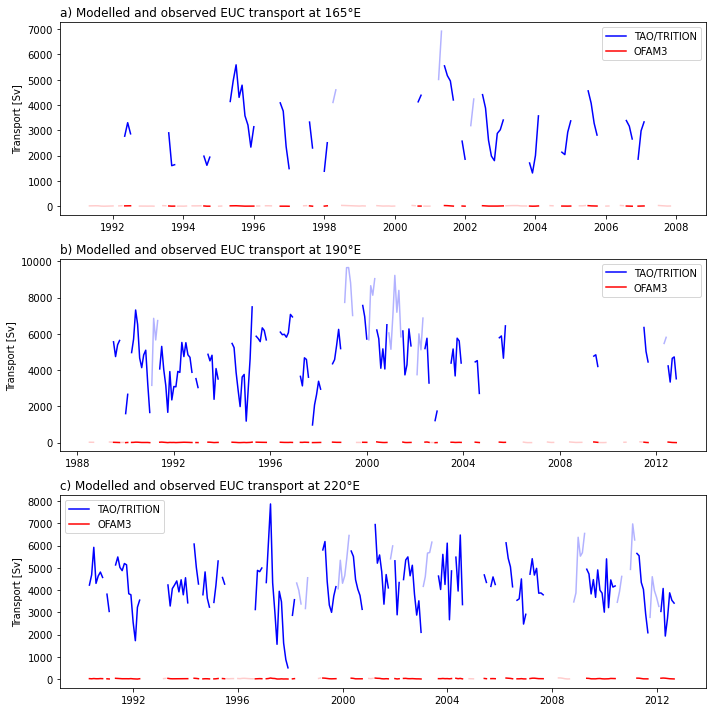

In [184]:

time_bnds_ofam = [[10*12+3, 27*12+1], [7*12+4, -1], [9*12+4, -1]]
time_bnds_tao = [[0, -1], [0, 24*12+8], [0, 22*12+8]]

fig = plt.figure(figsize=(10, 10))
for i in range(3):
    # TAO/TRITION slice.
    du = ds_sum[i].isel(time=slice(time_bnds_tao[i][0], time_bnds_tao[i][1]))
    
    # Rename TAO time array (so it matches OFAM3).
    duc = du.rename({'time': 'Time'})

    # Convert TAO time array to monthly, as ofam/tao days are different.
    duc.coords['Time'] = duc['Time'].values.astype('datetime64[M]')    
    
    # OFAM3 slice.
    dtx = dtt.sel(xu_ocean=lx['lons'][i])
    dtx = dtx.isel(Time=slice(time_bnds_ofam[i][0], time_bnds_ofam[i][1]))
    
    # Mask OFAM3 transport when TAO data is missing (and vise versa).
    dtc = dtx.where(np.isnan(duc) == False)
    dtc_nan = dtx.where(np.isnan(duc))  # OFAM3 when TAO missing.
    dux = duc.where(np.isnan(dtc) == False)
    dux_nan = duc.where(np.isnan(dtc)) # TAO when OFAM3 missing.
    
    SV = 1e6
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_title('{}Modelled and observed EUC transport at {}°E'.format(
        lx['l'][i], lx['lons'][i]), loc='left')
    ax.plot(dux.Time, (dux*m[i] + b[i])/1, color='blue', label='TAO/TRITION')
    ax.plot(dtc.Time, dtc/SV, color='red', label='OFAM3')
    
    # Increase alpha of transport when available, but doesn't match.
    ax.plot(dux.Time, (dux_nan*m[i] + b[i])/1, color='blue', alpha=0.3)
    ax.plot(dtc.Time, dtc_nan/SV, color='red', alpha=0.2)
    
    ax.set_ylabel('Transport [Sv]')
    ax.legend()
plt.tight_layout()
plt.savefig(fpath.joinpath('tao', 'EUC_transport_regression_z{}.png'.format(z1)))

In [165]:
b

array([ 0.61288685,  5.06961988, 11.12362141])

In [2]:
# def EUC_depths(du, depths, i, v_bnd=0.1, eps=0.05, index=False, log=True):

#     u = np.ma.masked_invalid(du)
#     # Maximum and minimum velocity at each time step.
#     v_max, v_min = np.nanmax(u, axis=1), np.nanmin(u, axis=1)

#     # Index of maximum and minimum velocity at each time.
#     v_imax, v_ibnd = np.nanargmax(u, axis=1), np.nanargmax(u, axis=1)

#     # Depth of maximum velocity.
#     depth_vmax = v_imax.copy()*np.nan

#     # Bottom depth levels (based on minimum velocity bound for the EUC).
#     depth_bnd = v_imax.copy()*np.nan  # mx_depth

#     count, empty = 0, 0

#     # Deepest velocity depth index (recalculated at each t is tao).
#     end = len(depths) - 1

#     for t in range(u.shape[0]): #
#         # Make sure entire slice isn't all empty.
#         if not (u[t] == True).mask.all() and not np.ma.is_masked(v_imax[t]):
#             # Find depth of maximum velocity.
#             depth_vmax[t] = depths[int(v_imax[t])].item()

#             # Find deepest velocity depth index.
#             end = np.ma.nonzero(u[t])[-1][-1]
#             # Make sure the end value isn't too much larger than v_bnd.
#             if u[t, end] <= v_bnd:
#                 # Velocity closest to v_bnd in the subset array.
#                 tmp = u[t, idx_1d(u[t, v_imax[t]+2:end+1], v_bnd)+v_imax[t]+2].item()
                
#                 # Depth index of the closet velocity (in the full array).
#                 v_ibnd[t] = np.argwhere(u[t] == tmp)[-1][-1]

#                 # Find that depth.
#                 depth_bnd[t] = depths[int(v_ibnd[t])]
#                 if depth_bnd[t] < 190: depth_bnd[t] = np.nan
#                 count += 1

#             else:
#                 empty += 1
#         else:
#             empty += 1
#     data_name = 'OFAM3' if hasattr(du, 'st_ocean') else 'TAO/TRITION'
# #     if log:
# #         logger.info('{} {}: v_bnd={} count={} tot={}, skipped={} empty={} eps={}.'
# #                     .format(data_name, lx['lons'][i], v_bnd, count, u.shape[0],
# #                             u.shape[0] - count - empty,  empty, eps))
#     if not index:
#         return v_max, depth_vmax, depth_bnd
#     else:
#         return v_max, v_imax, v_ibnd


INFO: Opening TAO mon data. Depth=slice(10, 360, None). SI=True


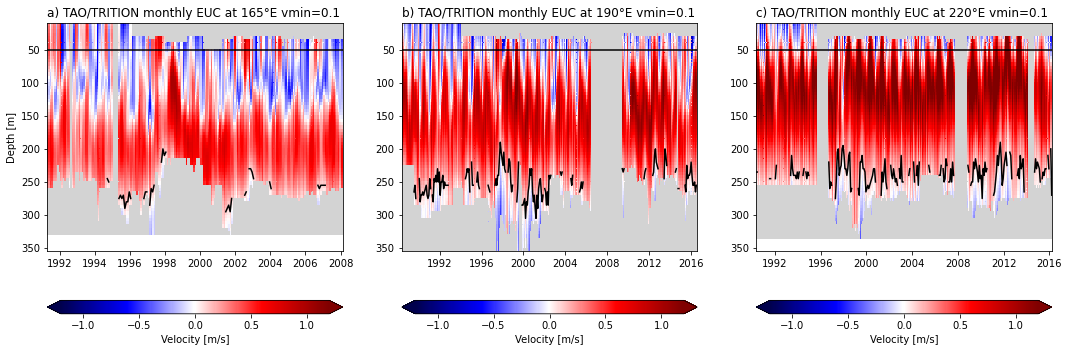

In [6]:
# # Saved data frequency (1 for monthly and 0 for daily data).
# T = 1

# # Open dataset of TAO data at the frequency.
# ds = open_tao_data(frq=lx['frq_short'][T], dz=slice(10, 360))
# v_bnd = 0.1  # m/s
# eps = np.round(v_bnd/2, 3)
# fig = plt.figure(figsize=(18, 6))
# for i, du in enumerate(ds):
#     name = '{}TAO/TRITION {} EUC at {}°E vmin={}'.format(lx['l'][i],
#                                                          lx['frq_long'][T],
#                                                          lx['lons'][i], v_bnd)
#     u = du.u_1205.transpose('depth', 'time')
#     ax = plot_eq_velocity(fig, du.depth, du.time, u, i + 1, name)
#     umx, depth_max, depth_end = EUC_depths(du.u_1205, du.depth, i,
#                                            v_bnd=v_bnd, eps=eps)

#     ax.plot(du.time, depth_end, 'k')
#     ax.axhline(50, color='k')